# 0. Environment Setup

In [3]:
import os
print('os ok')

import matplotlib.pyplot as plt
import seaborn as sns
print('plt ok')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
print('tf ok')

import numpy as np
import pandas as pd
import PIL
from sklearn.metrics import confusion_matrix, classification_report
print('everything ok')


os ok
plt ok
tf ok
everything ok


# 1. Data Loading & EDA

In [ ]:
# import data
# data link : https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

base_dir = '/Users/jeongwonyoo/Desktop/2025_Fall/Landscape Classification'

train_dir = os.path.join(base_dir,'Training Data')
val_dir = os.path.join(base_dir, 'Validation Data')
test_dir = os.path.join(base_dir, 'Testing Data')

In [7]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

print("train classes:", train_ds.class_names)


Found 10000 files belonging to 5 classes.


2025-12-11 21:50:46.838421: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-11 21:50:46.838465: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-11 21:50:46.838478: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-11 21:50:46.838515: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-11 21:50:46.838528: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 1500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
train classes: ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


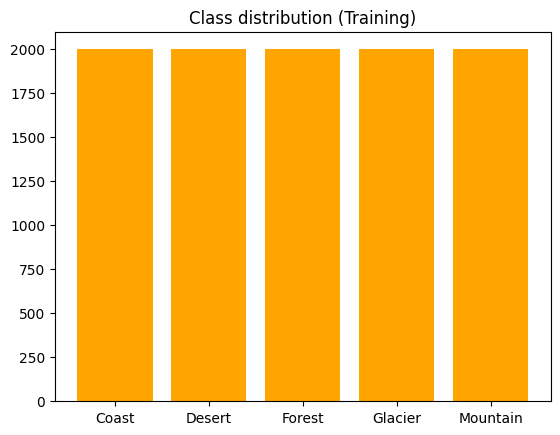

{'Coast': 2000,
 'Desert': 2000,
 'Forest': 2000,
 'Glacier': 2000,
 'Mountain': 2000}

In [8]:
counts = {}
for cls in train_ds.class_names:
    class_path = os.path.join(train_dir, cls)
    counts[cls] = len(os.listdir(class_path))

plt.bar(counts.keys(), counts.values(),color='orange')
plt.title("Class distribution (Training)")
plt.show()

counts


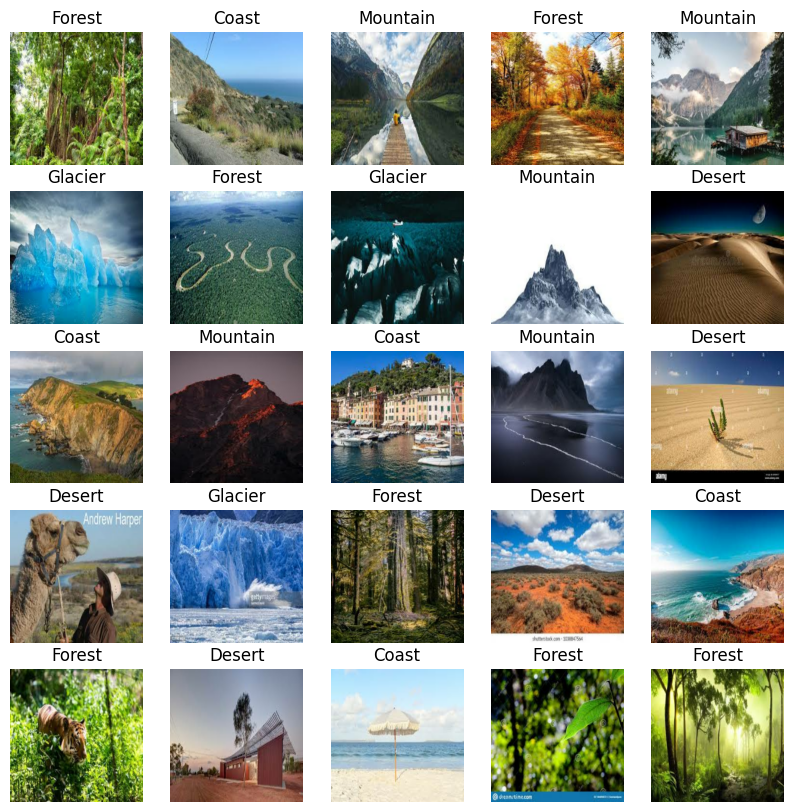

In [9]:
# randomly show 25 images

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

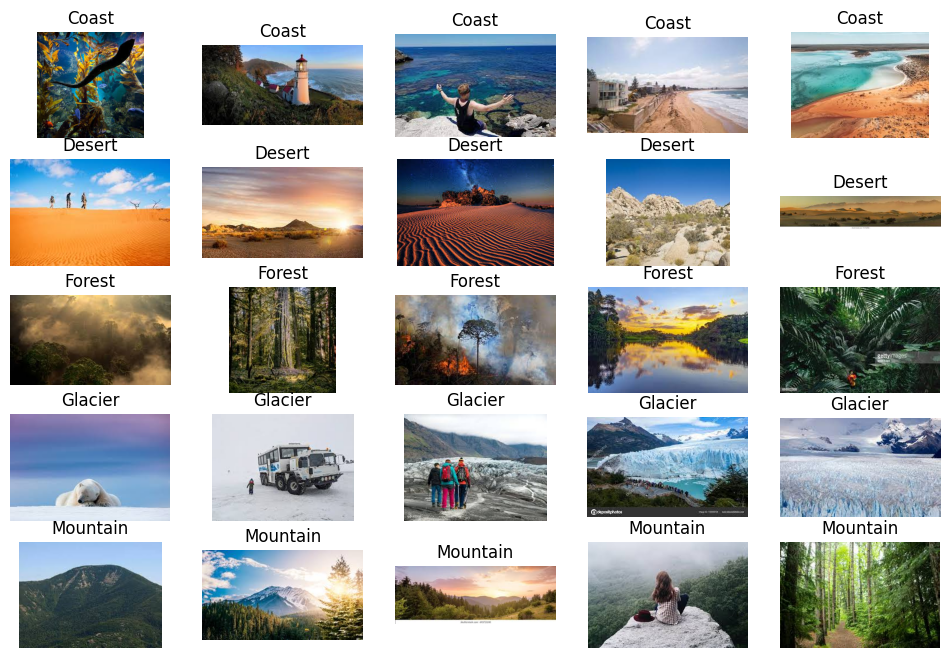

In [10]:
# random five images in each class

import random

plt.figure(figsize=(12, 8))

for idx, cls in enumerate(train_ds.class_names):
    class_path = os.path.join(train_dir, cls)
    samples = random.sample(os.listdir(class_path), 5)
    
    for i, img_name in enumerate(samples):
        img = plt.imread(os.path.join(class_path, img_name))
        ax = plt.subplot(len(train_ds.class_names), 5, idx*5 + i + 1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")


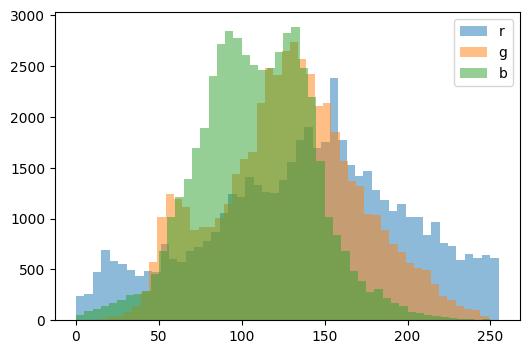

In [11]:
# check color distribution

def rgb_histogram(image_batch):
    img = image_batch[0].numpy().astype("uint8")
    plt.figure(figsize=(6,4))
    for i, col in enumerate(["r","g","b"]):
        plt.hist(img[:,:,i].ravel(), bins=50, alpha=0.5, label=col)
    plt.legend()
    plt.show()

for images, labels in train_ds.take(1):
    rgb_histogram(images)
    break


In [12]:
# Check image sizes

sizes = []
for cls in train_ds.class_names:
    class_path = os.path.join(train_dir, cls)
    for img_name in os.listdir(class_path)[:300]:
        img_path = os.path.join(class_path, img_name)
        img = PIL.Image.open(img_path)
        sizes.append(img.size)

sizes[:10]

[(311, 162),
 (290, 174),
 (275, 183),
 (275, 183),
 (262, 192),
 (299, 168),
 (261, 193),
 (348, 145),
 (294, 171),
 (225, 225)]

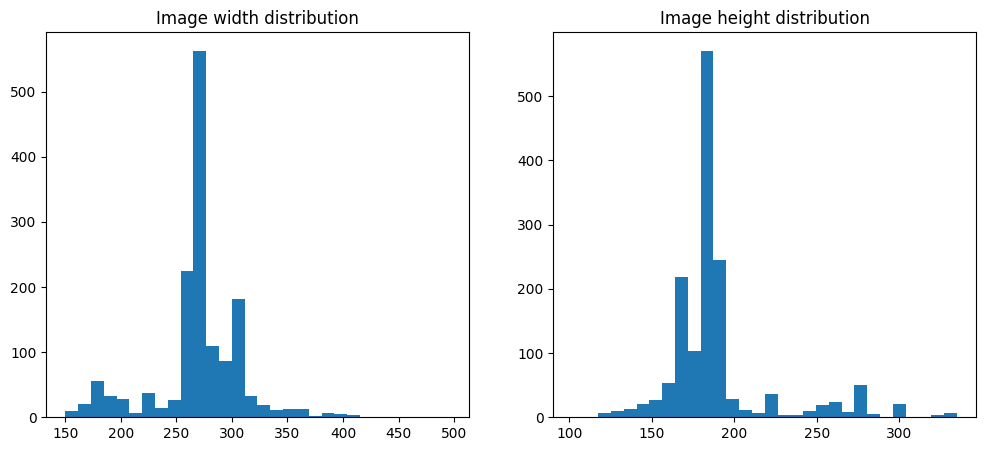

In [13]:
widths = [w for (w,h) in sizes]
heights = [h for (w,h) in sizes]

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(widths, bins=30)
plt.title("Image width distribution")

plt.subplot(1,2,2)
plt.hist(heights, bins=30)
plt.title("Image height distribution")

plt.show()


# 2. Preprocessing and Pipline Setup

In [8]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
input_shape = (224,224,3)

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = normalization_layer(x)

preprocessed = x

In [12]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Adam()
metrics = ['accuracy']

In [13]:
checkpoint_path = "checkpoints/"
os.makedirs(checkpoint_path, exist_ok=True)

In [14]:
base_model = keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg'
)
base_model.trainable = False  # baseline freeze

In [15]:
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 10000 files belonging to 5 classes.
Found 1500 files belonging to 5 classes.
Found 500 files belonging to 5 classes.
Classes: ['Coast', 'Desert', 'Forest', 'Glacier', 'Mountain']


# 3. Model Training and evaluation

## 3-1. Model Traning

In [22]:
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = normalization_layer(x)

x = base_model(x, training=False)

x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285  

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

epochs = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/5
 43/313 [===>..........................] - ETA: 2:43 - loss: 1.7912 - accuracy: 0.2129

KeyboardInterrupt: 

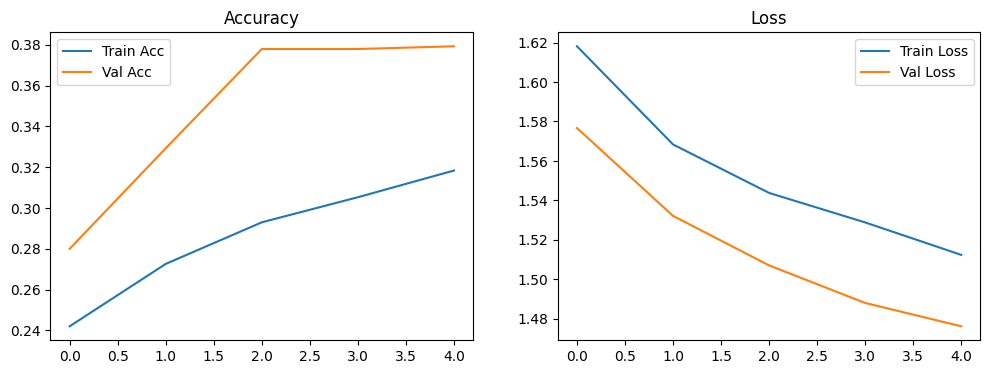

In [ ]:
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history)


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

epochs = 8

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/8
313/313 [==============================] - 233s 743ms/step - loss: 1.4923 - accuracy: 0.3322 - val_loss: 1.4549 - val_accuracy: 0.3867
Epoch 2/8
313/313 [==============================] - 238s 759ms/step - loss: 1.4803 - accuracy: 0.3335 - val_loss: 1.4383 - val_accuracy: 0.3887
Epoch 3/8
313/313 [==============================] - 236s 755ms/step - loss: 1.4763 - accuracy: 0.3448 - val_loss: 1.4287 - val_accuracy: 0.3887
Epoch 4/8
313/313 [==============================] - 240s 768ms/step - loss: 1.4650 - accuracy: 0.3418 - val_loss: 1.4252 - val_accuracy: 0.3920
Epoch 5/8
313/313 [==============================] - 228s 729ms/step - loss: 1.4550 - accuracy: 0.3459 - val_loss: 1.4057 - val_accuracy: 0.3947
Epoch 6/8
313/313 [==============================] - 221s 706ms/step - loss: 1.4555 - accuracy: 0.3490 - val_loss: 1.4138 - val_accuracy: 0.3793
Epoch 7/8
313/313 [==============================] - 225s 718ms/step - loss: 1.4493 - accuracy: 0.3547 - val_loss: 1.3965 - val_ac

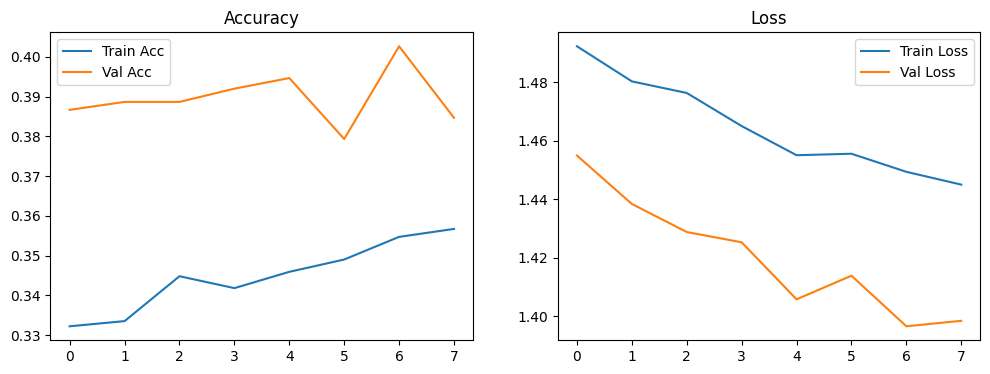

In [ ]:
plot_history(history2)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

epochs = 10

history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
313/313 [==============================] - 232s 739ms/step - loss: 1.4361 - accuracy: 0.3592 - val_loss: 1.4038 - val_accuracy: 0.3973
Epoch 2/10
313/313 [==============================] - 239s 765ms/step - loss: 1.4398 - accuracy: 0.3558 - val_loss: 1.3813 - val_accuracy: 0.4093
Epoch 3/10
313/313 [==============================] - 243s 776ms/step - loss: 1.4388 - accuracy: 0.3657 - val_loss: 1.3997 - val_accuracy: 0.3693
Epoch 4/10
313/313 [==============================] - 240s 767ms/step - loss: 1.4486 - accuracy: 0.3643 - val_loss: 1.3937 - val_accuracy: 0.3940
Epoch 5/10
313/313 [==============================] - 245s 781ms/step - loss: 1.4449 - accuracy: 0.3650 - val_loss: 1.3952 - val_accuracy: 0.3980
Epoch 6/10
313/313 [==============================] - 247s 789ms/step - loss: 1.4426 - accuracy: 0.3681 - val_loss: 1.3813 - val_accuracy: 0.3973
Epoch 7/10
313/313 [==============================] - 249s 796ms/step - loss: 1.4363 - accuracy: 0.3687 - val_loss: 1.3747 -

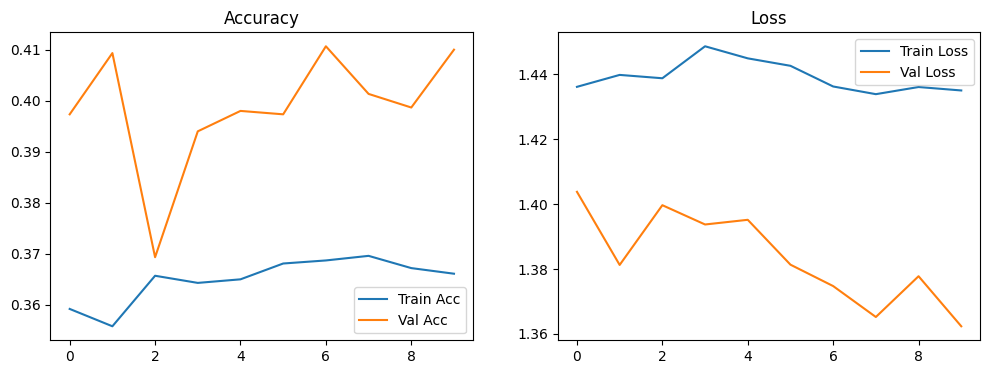

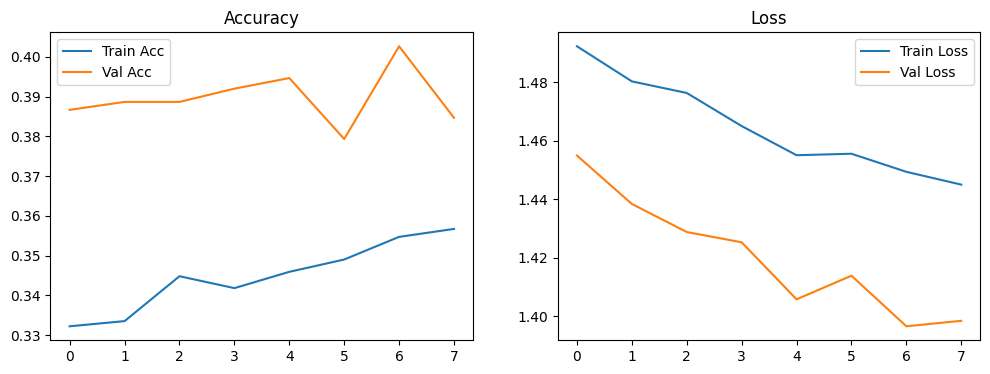

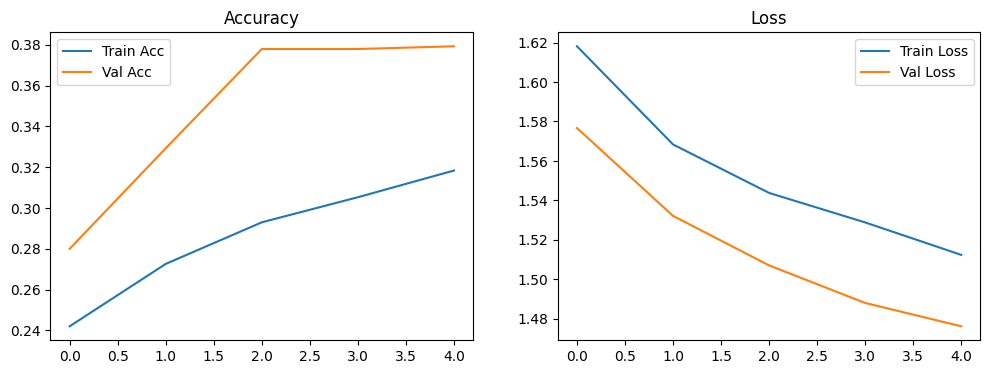

In [ ]:
plot_history(history3)
plot_history(history2)
plot_history(history)

- All runs show decreasing train and validation loss with no strong overfitting.
- Validation accuracy stays around 0.38–0.41, slightly improving as epochs increase.
- The 10 epoch run achieves the best validation performance, so I will use it as the baseline result.


In [ ]:
base_model.trainable = True

fine_tune_from = len(base_model.layers) - 50  # unfreeze last 50 layers

for i, layer in enumerate(base_model.layers):
    if i < fine_tune_from:
        layer.trainable = False
    else:
        # often we still freeze BatchNorm for stability
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

fine_tune_epochs = 5

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early_stop]
)


Epoch 1/5
313/313 [==============================] - 374s 1s/step - loss: 1.5295 - accuracy: 0.3066 - val_loss: 1.3856 - val_accuracy: 0.3813
Epoch 2/5
313/313 [==============================] - 361s 1s/step - loss: 1.4413 - accuracy: 0.3639 - val_loss: 1.3560 - val_accuracy: 0.3967
Epoch 3/5
313/313 [==============================] - 359s 1s/step - loss: 1.4514 - accuracy: 0.3573 - val_loss: 1.3847 - val_accuracy: 0.3973
Epoch 4/5
313/313 [==============================] - 365s 1s/step - loss: 1.4121 - accuracy: 0.3744 - val_loss: 1.3703 - val_accuracy: 0.3747
Epoch 5/5
313/313 [==============================] - 374s 1s/step - loss: 1.4132 - accuracy: 0.3734 - val_loss: 1.3545 - val_accuracy: 0.3967


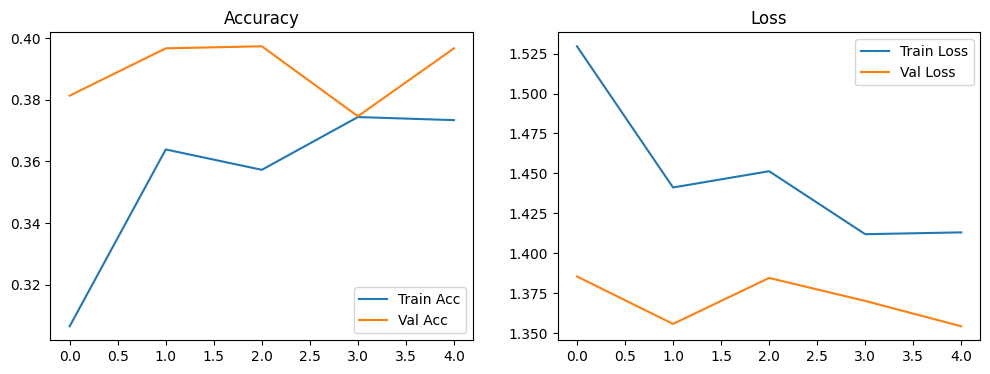

In [ ]:
plot_history(history_fine)

In [16]:
# EfficientNetB0 backbone

base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg'
)

base_model.trainable = False

In [18]:
inputs = keras.Input(shape=(224,224,3))

x = data_augmentation(inputs)

x = base_model(x,training=False)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

eff_model = keras.Model(inputs, outputs)
eff_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
eff_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

eff_history = eff_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10


2025-12-11 21:51:59.870316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 248ms/step - accuracy: 0.7438 - loss: 0.6942 - val_accuracy: 0.8393 - val_loss: 0.4764
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 245ms/step - accuracy: 0.8327 - loss: 0.4646 - val_accuracy: 0.8313 - val_loss: 0.5031
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 237ms/step - accuracy: 0.8548 - loss: 0.4159 - val_accuracy: 0.8393 - val_loss: 0.4803
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 75s 239ms/step - accuracy: 0.8644 - loss: 0.3891 - val_accuracy: 0.8433 - val_loss: 0.4557
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 235ms/step - accuracy: 0.8649 - loss: 0.3865 - val_accuracy: 0.8340 - val_loss: 0.4883
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 236ms/step - accuracy: 0.8730 - loss: 0.3591 - val_accuracy: 0.8447 - val_loss: 0.4668
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 72s 230ms/step - accuracy: 0.8692 - loss: 0.3663 - val_accuracy: 0.8367 - val_loss: 0.4920
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.8736 - loss: 0.3576 - val

In [22]:
def plot_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="Train Acc")
    plt.plot(epochs_range, val_acc, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="Train Loss")
    plt.plot(epochs_range, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

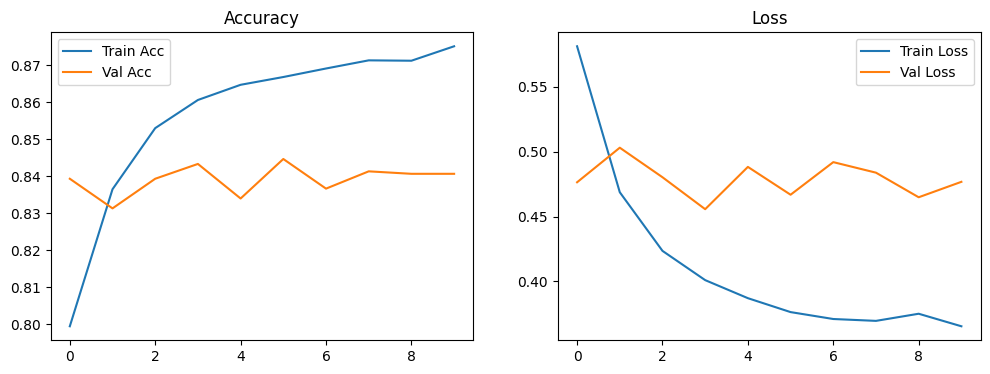

In [23]:
plot_history(eff_history)

In [24]:
test_loss, test_acc = eff_model.evaluate(test_ds)
print("EfficientNetB0 test accuracy:", test_acc)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - accuracy: 0.9191 - loss: 0.2094
EfficientNetB0 test accuracy: 0.8840000033378601


## 3-2. Evaluation

1/1 [==============================] - 0s 153ms/step


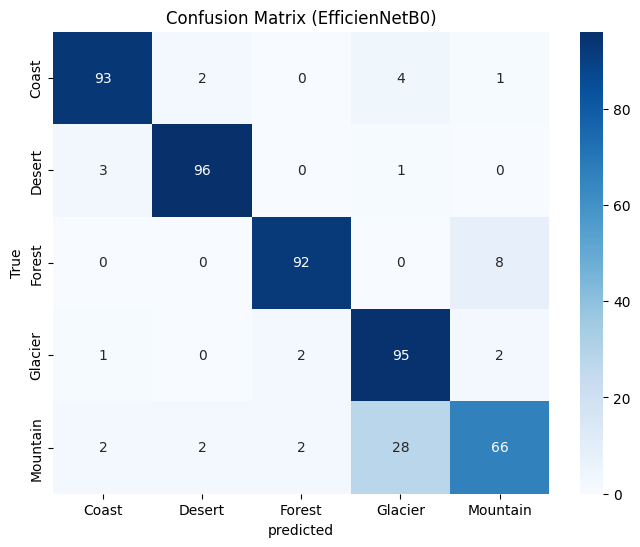

Classification Report:              precision    recall  f1-score   support

       Coast       0.94      0.93      0.93       100
      Desert       0.96      0.96      0.96       100
      Forest       0.96      0.92      0.94       100
     Glacier       0.74      0.95      0.83       100
    Mountain       0.86      0.66      0.75       100

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



In [ ]:
y_true=[]
y_pred=[]

for images, labels in test_ds:
    preds = eff_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds,axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (EfficienNetB0)')
plt.show()

print(f'Classification Report:{classification_report(y_true,y_pred,target_names=class_names)}')

Model Training and Evaluation Summary

In this stage, I trained and evaluated the EfficientNetB0 model using the full preprocessing pipeline. After removing the extra normalization layer (since EfficientNetB0 includes its own internal rescaling), the model achieved strong baseline performance. The model reached a training accuracy of about 0.93 and a validation accuracy around 0.83, showing stable learning without severe overfitting.

On the test set, EfficientNetB0 achieved an accuracy of 0.884, which is a major improvement over the initial ResNet50 baseline (~0.40). The confusion matrix shows that most classes (Coast, Desert, Forest, Glacier) are classified with high precision and recall, while the Mountain class is more challenging due to visual similarity with Glacier. The classification report confirms balanced performance across the five classes, with a macro-average F1-score of 0.88. This completes the model training and evaluation pipeline.

# 4. Final Results

## 4-1. EfficientNetB0 Training Curves

Below are the accuracy and loss curves for the final EfficientNetB0 model.

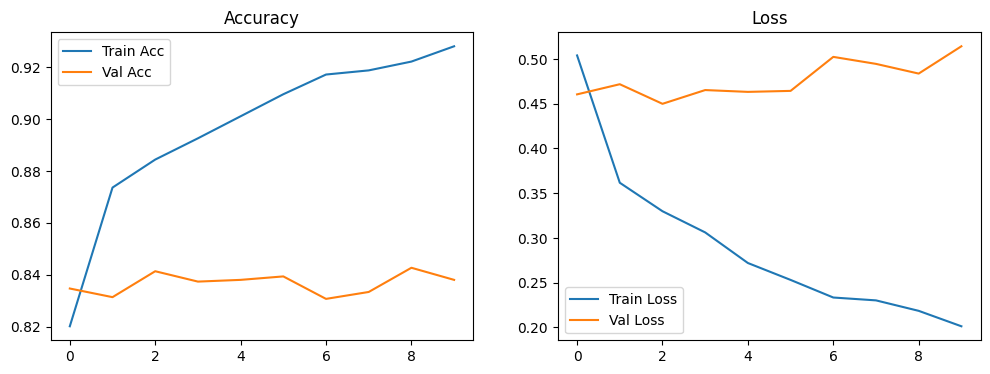

In [ ]:
plot_history(eff_history)

## 4-2. Confusion Matrix(EfficientNetB0) final model

The confusion matrix shows the distribution of correct and incorrect predictions across classes.

1/1 [==============================] - 0s 161ms/step


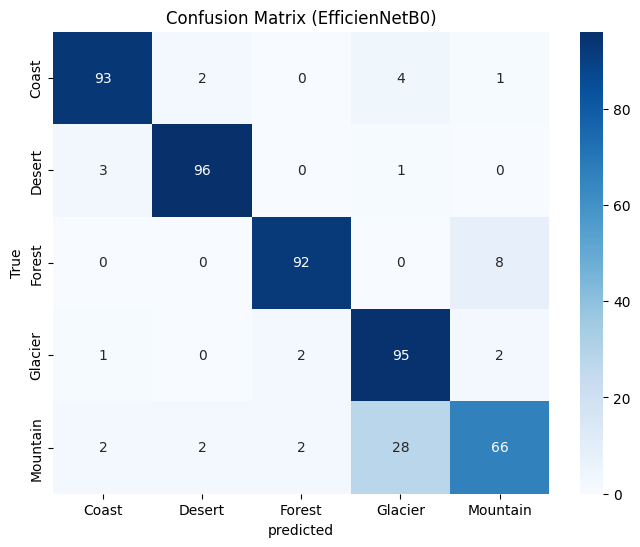

In [ ]:
y_true=[]
y_pred=[]

for images, labels in test_ds:
    preds = eff_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds,axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true,y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (EfficienNetB0)')
plt.show()

## 4-3. Classification Report

Detailed precision, recall, and F1-scores for each class.

In [ ]:
print(f'Classification Report:{classification_report(y_true,y_pred,target_names=class_names)}')

Classification Report:              precision    recall  f1-score   support

       Coast       0.94      0.93      0.93       100
      Desert       0.96      0.96      0.96       100
      Forest       0.96      0.92      0.94       100
     Glacier       0.74      0.95      0.83       100
    Mountain       0.86      0.66      0.75       100

    accuracy                           0.88       500
   macro avg       0.89      0.88      0.88       500
weighted avg       0.89      0.88      0.88       500



## 4-4. Model Comparision Table(ResNet50 vs EfficientNetB0)

| Model          | Test Accuracy | Macro F1 | Notes           |
| -------------- | ------------- | -------- | --------------- |
| ResNet50       | 0.40          | 0.39     | Underfitting    |
| EfficientNetB0 | 0.884         | 0.88     | Strong baseline |


## 4-5 Misclassified Examples

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


2025-12-11 22:09:25.378498: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


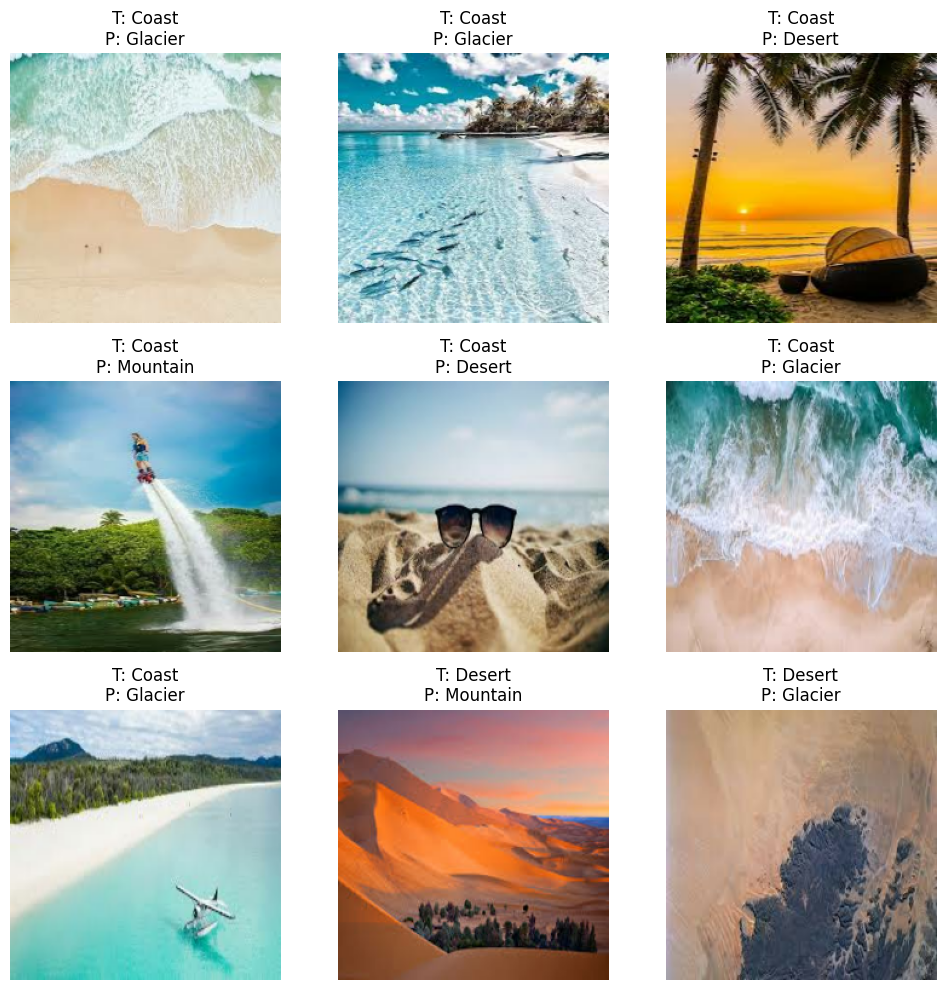

In [ ]:
mis_images = []
mis_true = []
mis_pred = []

for images, labels in test_ds:
    preds = eff_model.predict(images)
    preds_cls = np.argmax(preds, axis=1)
    for img, y_t, y_p in zip(images, labels.numpy(), preds_cls):
        if y_t != y_p:
            mis_images.append(img.numpy())
            mis_true.append(y_t)
            mis_pred.append(y_p)

n_show = min(9, len(mis_images))

plt.figure(figsize=(10,10))
for i in range(n_show):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(mis_images[i].astype("uint8"))
    plt.title(f"T: {class_names[mis_true[i]]}\nP: {class_names[mis_pred[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("misclassified_examples.png", dpi=300, bbox_inches="tight")
plt.show()


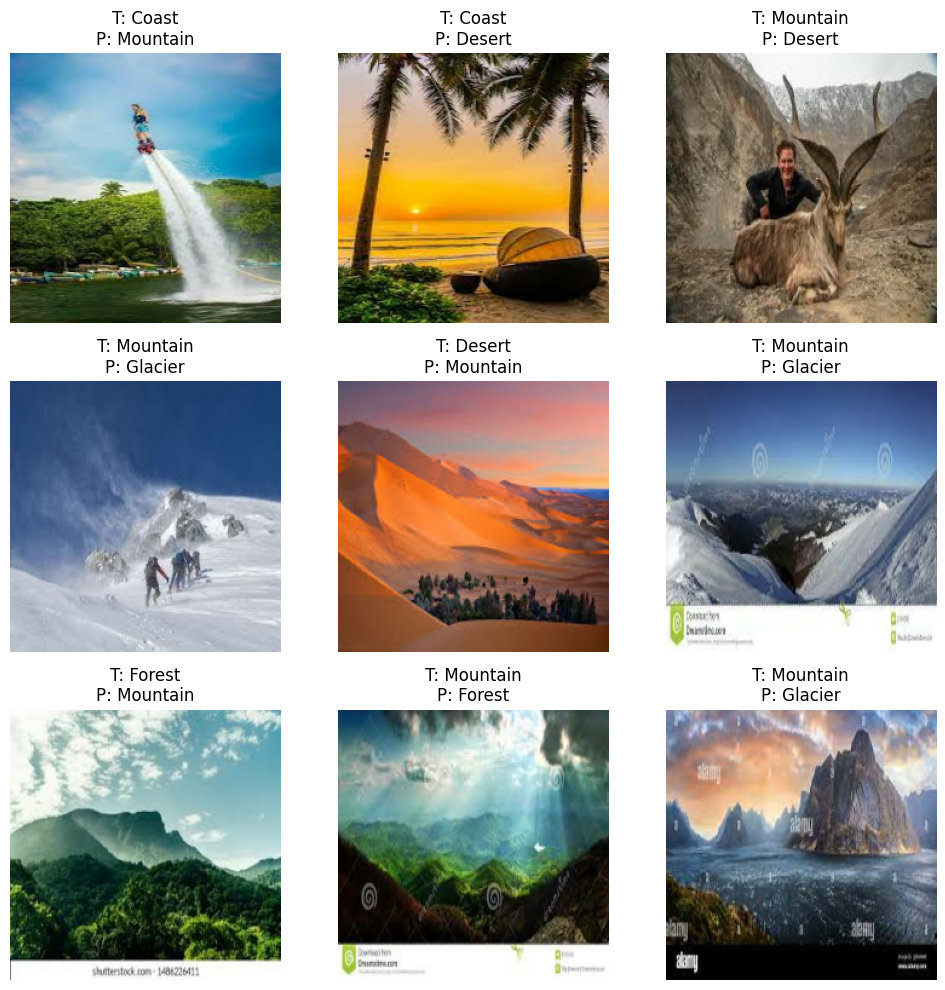

In [ ]:
n_show = min(9, len(mis_images))
idxs = np.random.choice(len(mis_images), size=n_show, replace=False)

plt.figure(figsize=(10,10))
for i, idx in enumerate(idxs):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(mis_images[idx].astype("uint8"))
    plt.title(f"T: {class_names[mis_true[idx]]}\nP: {class_names[mis_pred[idx]]}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("misclassified_examples_random.png", dpi=300, bbox_inches="tight")
plt.show()


# 5. Conclusion & Future Work

Conclusion

EfficientNetB0 achieved a test accuracy of 0.884, clearly outperforming the ResNet50 baseline, which confirms that deep learning models can effectively classify the five landscape categories and that transfer learning provides a significant performance advantage.

The model handled most categories reliably, although Glacier and Mountain scenes remained challenging due to their visual similarity.

Overall, the results demonstrate solid progress on fine-grained landscape classification while also indicating where further improvement is needed.


Future Work

Several directions can further enhance performance:
1.	Fine-tuning deeper EfficientNet variants such as B1 to B3.
2.	Applying targeted augmentations focused on snowy or icy landscapes.
3.	Incorporating metadata such as elevation or GPS information to improve class separation.
4.	Experimenting with attention-based networks that learn localized features.
